In [402]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft
from IPython.display import Audio

plt.rcdefaults()

In [403]:
sample_rate, data = wavfile.read('8403__speedy__clean_g_str_pluck.wav')


# Play the audio
Audio(data=data, rate=sample_rate)

The signal is at 195Hz

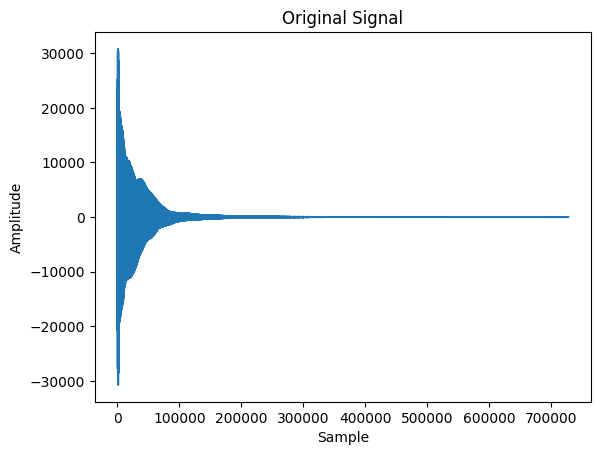

In [404]:
plt.plot(data)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Original Signal')
plt.show()

Sample Rate: 44100
Data: [ 1.29912309e-03  1.20168886e-03  9.74342319e-04 ...  0.00000000e+00
  3.24780773e-05 -3.24780773e-05]


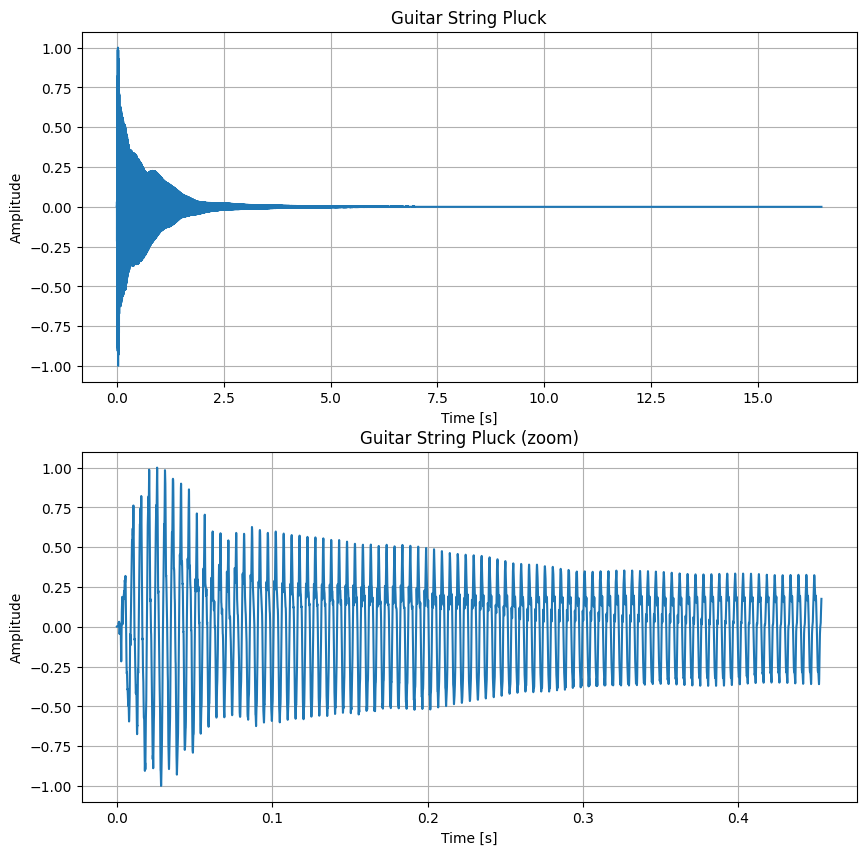

In [405]:

time = np.linspace(0, len(data) / sample_rate, num=len(data))
data = data/np.max(data) # normalize data

print(f"Sample Rate: {sample_rate}")
print(f"Data: {data}")

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.title('Guitar String Pluck')

plt.subplot(2, 1, 2)
plt.plot(time[0:20000], data[0:20000])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.title('Guitar String Pluck (zoom)')

plt.show()

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


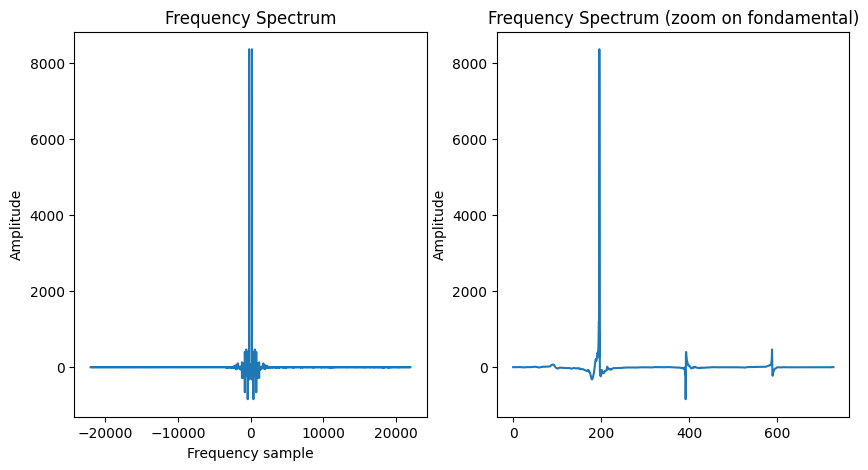

In [406]:
# compute fft
data_fft = fft(data)
data_fft_frequencies = np.fft.fftfreq(len(data), 1/sample_rate)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(data_fft_frequencies, data_fft)
plt.xlabel('Frequency sample')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')

plt.subplot(1, 2, 2)
plt.plot(data_fft_frequencies[0:12000], data_fft[0:12000])
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum (zoom on fondamental)')
plt.show()

In [407]:
# fondamental frequency
fundamental_freq = int(np.argmax(data_fft) * sample_rate / len(data_fft))
print(f"Fundamental Frequency: {data_fft_frequencies[np.argmax(data_fft)]} Hz")
print(f"Fundamental Frequency: {fundamental_freq} Hz")

Fundamental Frequency: 195.8296488928801 Hz
Fundamental Frequency: 195 Hz


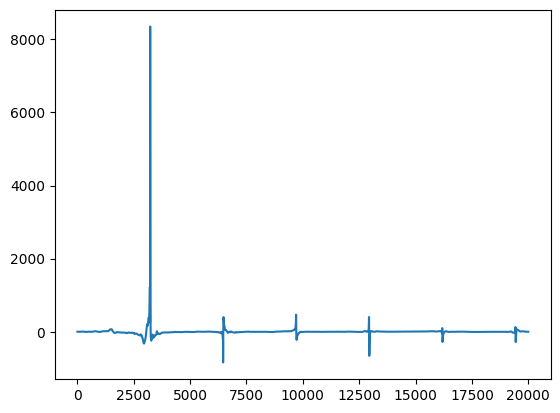

In [408]:
plt.plot(data_fft[0:20000])
plt.show()

Harmonic 0: 195.82964889288007 Hz, Amplitude: 8352.613650899333
Harmonic 1: 392.9935350962722 Hz, Amplitude: 400.93794992576863
Harmonic 2: 588.2773596348519 Hz, Amplitude: 465.40070336782674
Harmonic 3: 784.4102442801211 Hz, Amplitude: 402.8505562762015
Harmonic 4: 981.3921890320797 Hz, Amplitude: 99.16843906150905
Harmonic 5: 1177.9496037306938 Hz, Amplitude: 86.75411032058652
Harmonic 6: 1373.7792526235737 Hz, Amplitude: 7.528016782947228
Harmonic 7: 1569.608901516454 Hz, Amplitude: 4.2859328669183805
Harmonic 8: 1763.9830187978662 Hz, Amplitude: 8.643301188391323


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5072\1166131517.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  amplitudes[i-1] = data_fft[idx]


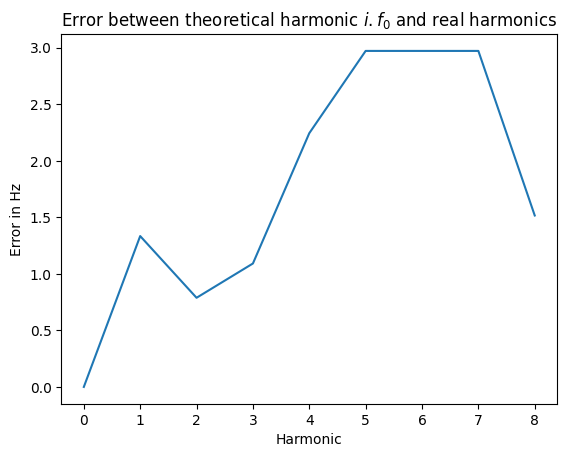

In [409]:
# Extract harmonics and amplitudes

harmonics = np.zeros(9)
th_harmonics = np.zeros(9)
amplitudes = np.zeros(9)

for i in range(1, 10):
    th_harmonic = i * fundamental_freq # theoretical harmonic
    th_idx = i*np.argmax(data_fft)
    idx = np.argmax(data_fft[th_idx - 50 :th_idx + 50]) + th_idx - 50
    harmonics[i-1] = idx # real harmonic
    th_harmonics[i-1] = th_idx
    amplitudes[i-1] = data_fft[idx]

harmonics = harmonics * sample_rate / len(data_fft)
th_harmonics = th_harmonics * sample_rate / len(data_fft)

for i in range(len(harmonics)):
    print(f"Harmonic {i}: {harmonics[i]} Hz, Amplitude: {amplitudes[i]}")

err = np.abs(th_harmonics - harmonics) 
plt.xlabel('Harmonic')
plt.ylabel('Error in Hz')
plt.title(r'Error between theoretical harmonic $i. f_0$ and real harmonics')
plt.plot(err)

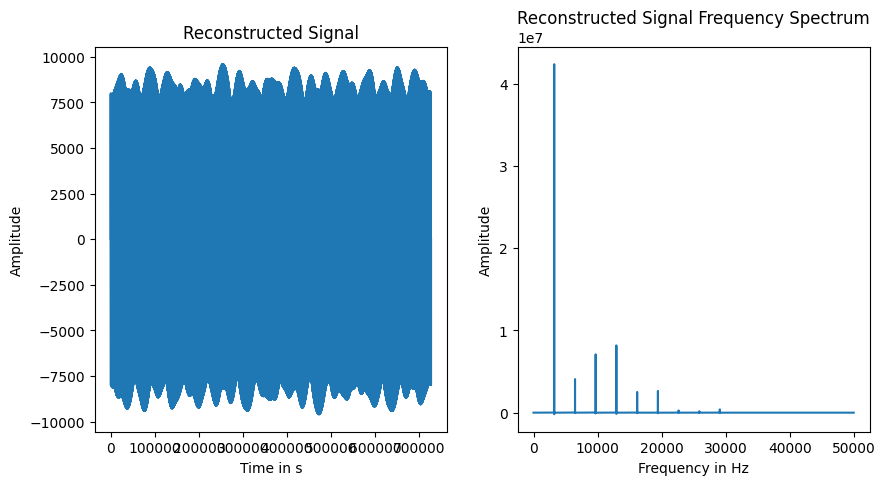

In [410]:
# Generate a signal with the same harmonics
signal = np.zeros(len(data))
time = np.linspace(0, len(data) / sample_rate, len(data))
for i in range(len(harmonics)):
    signal += amplitudes[i] * np.sin(2 * np.pi * harmonics[i] * time)

fft_signal = fft(signal)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.title('Reconstructed Signal')
plt.plot(signal)

plt.subplot(1, 2, 2)
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.title('Reconstructed Signal Frequency Spectrum')
plt.plot(fft_signal[0:50000])

plt.show()

As we can see it does not look like the initial signal. The is partly because the reconstructed signal is composed of every frequency component of the original signal without any decay in amplitude. To overcome this, we can use a window function based on a visual analysis of the original signal.

The window would ideally be of the form of the envelope of the original signal. 

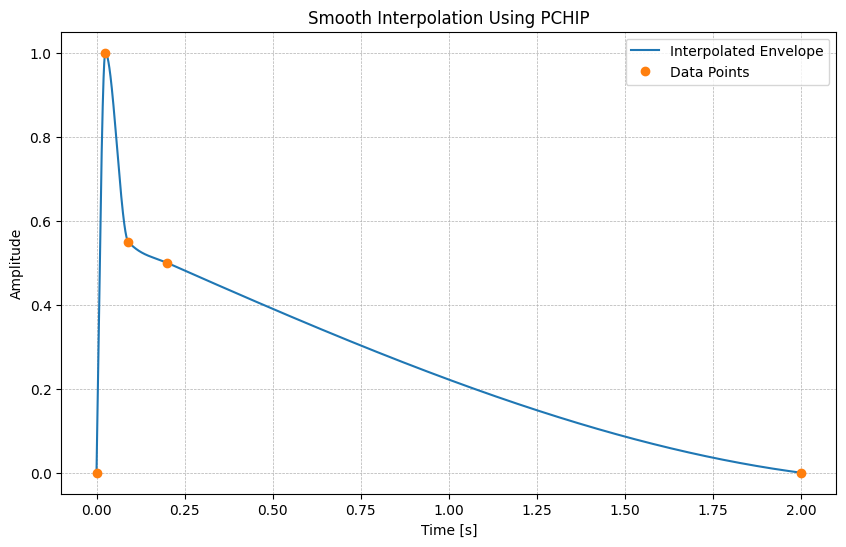

In [411]:
from scipy.interpolate import PchipInterpolator

# Your existing data
win = np.ones(len(data))
d_start_time = 0.025
s_start_time = 0.09
r_start_time = 0.2
stop_time = 2

d_start_amplitude = 1
s_start_amplitude = 0.55
r_start_amplitude = 0.5
stop_amplitude = 0

time_points = [0, d_start_time, s_start_time, r_start_time, stop_time]
amplitude_points = [0, d_start_amplitude, s_start_amplitude, r_start_amplitude, stop_amplitude]

# Create the interpolator
interpolator = PchipInterpolator(time_points, amplitude_points)

# Generate new time values
time_new = np.linspace(0, stop_time, len(data))
# Interpolated amplitudes
amplitude_new = interpolator(time_new)

# Apply the window to your data
windowed_data = data * amplitude_new

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_new, amplitude_new, label='Interpolated Envelope')
plt.plot(time_points, amplitude_points, 'o', label='Data Points')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Smooth Interpolation Using PCHIP')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

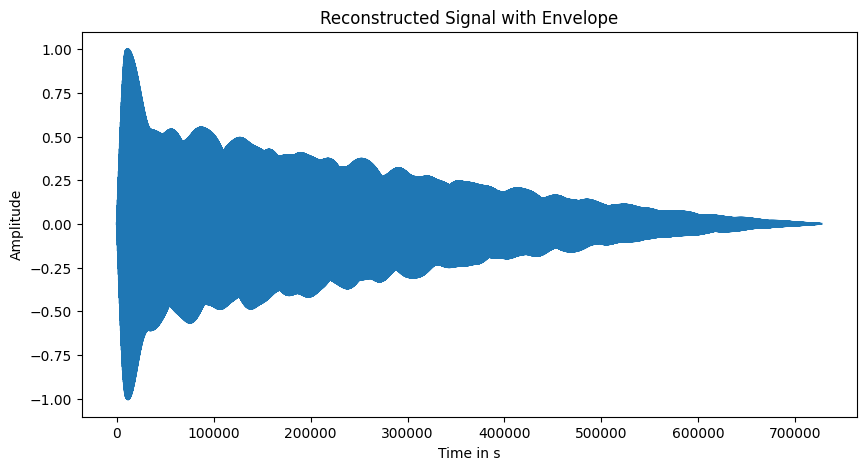

In [412]:
# Multipliy the reconstructed signal by the smooth curve
signal *= amplitude_new
signal = signal/np.max(signal)

plt.figure(figsize=(10, 5))
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.title('Reconstructed Signal with Envelope')
plt.plot(signal)

plt.show()


In [415]:
# Play the audio
print("Playing the original signal")
Audio(data=data, rate=sample_rate)

Playing the original signal


In [ ]:

print("Playing the reconstructed signal")
Audio(data=signal, rate=sample_rate)

Playing the original signal
Playing the reconstructed signal
